In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from utils import *

print(torch.cuda.is_available())
print(torch.device('cuda'))
print(torch.cuda.device_count())
print(torch.version.cuda)

True
cuda
3
11.2


In [2]:
# dataset 512
import opendatasets as od
import zipfile

# dataset 1024
import os
import zipfile
import gdown
from sklearn.model_selection import train_test_split

# mask
sys.path.append(os.path.abspath('/root/MAT/'))
from datasets import mask_generator_512, mask_generator_256

# eval
from evaluation import cal_fid_pids_uids, cal_lpips, cal_psnr_ssim_l1
import contextlib

# Others
import glob
import importlib
importlib.reload(cal_fid_pids_uids)
importlib.reload(cal_lpips)
importlib.reload(cal_psnr_ssim_l1)

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


<module 'evaluation.cal_psnr_ssim_l1' from '../evaluation/cal_psnr_ssim_l1.py'>

## Understand code

### Masks (```./datasets/mask*```)

In [5]:
!python datasets/mask_generator_512.py

datasets/mask_generator_512.py:51: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  mask.transpose(Image.FLIP_LEFT_RIGHT)
datasets/mask_generator_512.py:53: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  mask.transpose(Image.FLIP_TOP_BOTTOM)
0.6009354305267334


In [6]:
!python datasets/mask_generator_512_small.py

datasets/mask_generator_512_small.py:51: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  mask.transpose(Image.FLIP_LEFT_RIGHT)
datasets/mask_generator_512_small.py:53: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  mask.transpose(Image.FLIP_TOP_BOTTOM)


0.7832531871795654


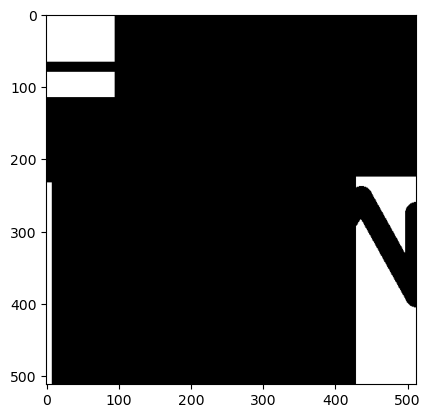

In [8]:
plt.imshow(mask_generator_512.RandomMask(512, [.8, 1])[0], cmap='gray')

### Generate img with stg1 (```./generate_image_having_stg1.py```, FFHQ)

In [51]:
%%time
!python generate_image_having_stg1.py \
    --network pretrained/CelebA-HQ_512.pkl \
    --dpath test_sets/CelebA-HQ/images3 \
    --mpath test_sets/CelebA-HQ/masks3 \
    --outdir test_sets/CelebA-HQ/samples3 \
    --out1dir test_sets/CelebA-HQ/samples3_stg1 \
    --large-mask True

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
Loading data from: test_sets/CelebA-HQ/images3
Loading mask from: test_sets/CelebA-HQ/masks3
Loading networks from: pretrained/CelebA-HQ_512.pkl
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
>>>>> 6.25%
>>>>> 12.5%
>>>>> 18.75%
>>>>> 25.0%
>>>>> 31.25%
>>>>> 37.5%
>>>>> 43.75%
>>>>> 50.0%
>>>>> 56.25%
>>>>> 62.5%
>>>>> 68.75%
>>>>> 75.0%
>>>>> 81.25%
>>>>> 87.5%
>>>>> 93.75%
>>>>> 100.0%
CPU times: user 132 ms, sys: 87.7 ms, total: 220 ms
Wall time: 13.4 s


### Visualize (```plot_images(...)```, FFHQ)

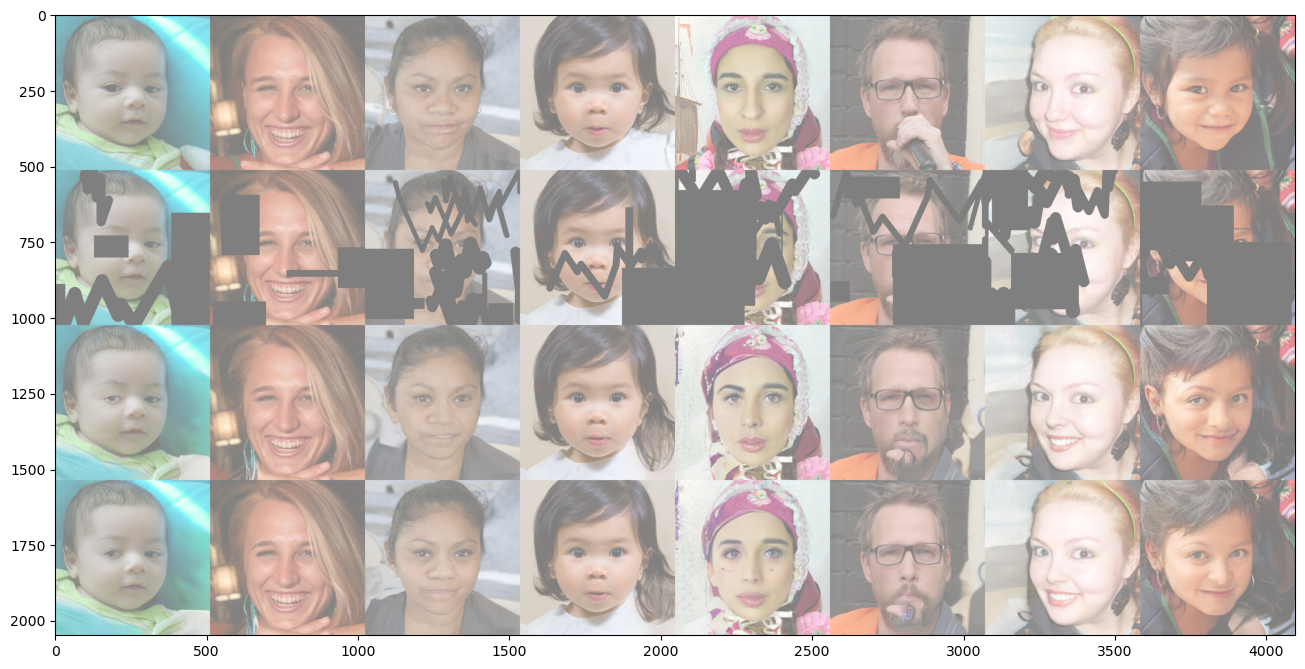

In [52]:
full_imgs = []

for i in range(8):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/images3/' + str(i) + '.png')[..., :-1])
for i in range(8):
    img = mpimg.imread('test_sets/CelebA-HQ/images3/' + str(i) + '.png')[..., :-1]
    mask = mpimg.imread('test_sets/CelebA-HQ/masks3/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/samples3_stg1/' + str(i) + '.png'))
for i in range(8):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/samples3/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

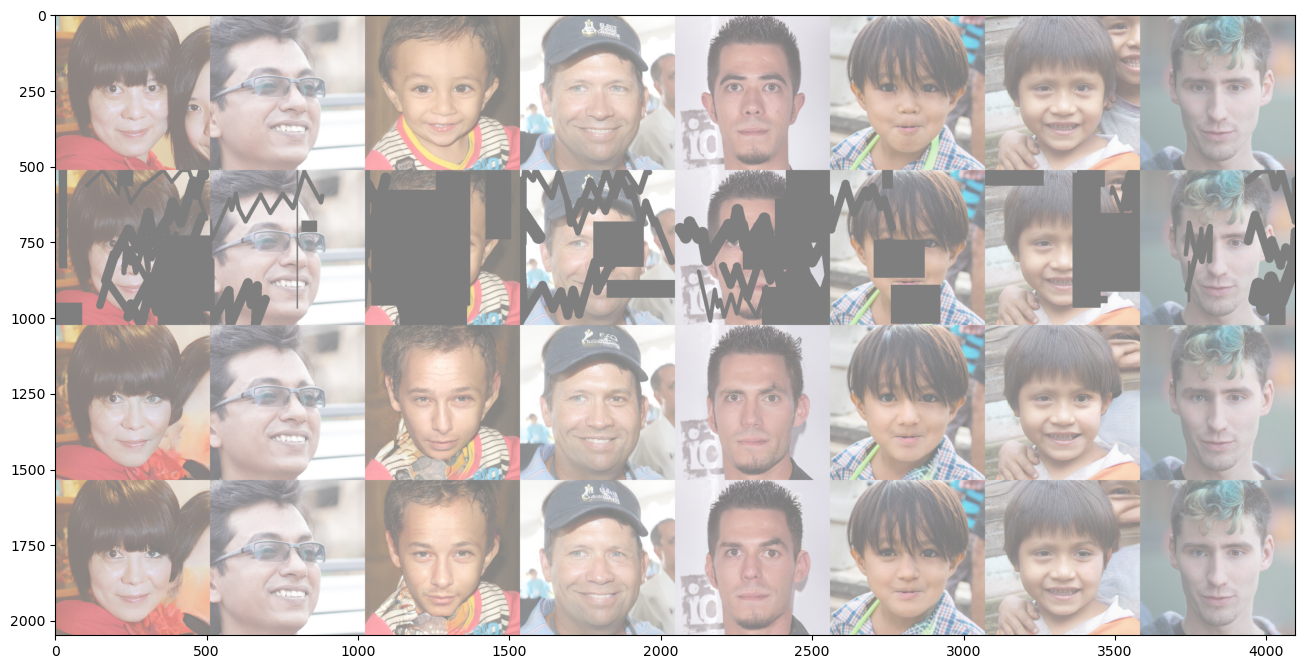

In [53]:
full_imgs = []

for i in range(8, 16):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/images3/' + str(i) + '.png')[..., :-1])
for i in range(8, 16):
    img = mpimg.imread('test_sets/CelebA-HQ/images3/' + str(i) + '.png')[..., :-1]
    mask = mpimg.imread('test_sets/CelebA-HQ/masks3/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8, 16):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/samples3_stg1/' + str(i) + '.png'))
for i in range(8, 16):
    full_imgs.append(mpimg.imread('test_sets/CelebA-HQ/samples3/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

### Eval (```./evaluation/*```, FFHQ)

In [54]:
with contextlib.redirect_stdout(None):
    fid1, pids1, uids1 = cal_fid_pids_uids.calculate_metrics('test_sets/CelebA-HQ/samples3_stg1/', 'test_sets/CelebA-HQ/images3/')
    lpips1 = cal_lpips.calculate_metrics('test_sets/CelebA-HQ/samples3_stg1/', 'test_sets/CelebA-HQ/images3/')
    psnr1, ssim1, l11 = cal_psnr_ssim_l1.calculate_metrics('test_sets/CelebA-HQ/samples3_stg1/', 'test_sets/CelebA-HQ/images3/')

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
with contextlib.redirect_stdout(None):
    fid, pids, uids = cal_fid_pids_uids.calculate_metrics('test_sets/CelebA-HQ/samples3/', 'test_sets/CelebA-HQ/images3/')
    lpips = cal_lpips.calculate_metrics('test_sets/CelebA-HQ/samples3/', 'test_sets/CelebA-HQ/images3/')
    psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics('test_sets/CelebA-HQ/samples3/', 'test_sets/CelebA-HQ/images3/')

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
print('fid stg1:', fid1)
print('pids stg1:', pids1)
print('uids stg1:', uids1)
print('lpips stg1:', lpips1)
print('psnr stg1:', psnr1)
print('ssim stg1:', ssim1)
print('l1 stg1:', l11)
print()
print('fid:', fid)
print('pids:', pids)
print('uids:', uids)
print('lpips:', lpips)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

fid stg1: 82.84141409174063
pids stg1: 0.0
uids stg1: 0.0
lpips stg1: 0.15561750694178045
psnr stg1: 21.021229104274227
ssim stg1: 0.8150791125577012
l1 stg1: 0.04210402825299431

fid: 74.20197743867784
pids: 0.0
uids: 0.0
lpips: 0.14042053103912622
psnr: 21.88083236511579
ssim: 0.8273340346533908
l1: 0.03861115243699816


### Gen-Vis-Eval (External raw img 512x512)

In [ ]:
%%time
!python generate_image_having_stg1.py \
    --network pretrained/CelebA-HQ_512.pkl \
    --dpath test_sets/CelebA-HQ/images4 \
    --maskdir test_sets/CelebA-HQ/masks4 \
    --outdir test_sets/CelebA-HQ/samples4 \
    --out1dir test_sets/CelebA-HQ/samples4_stg1 \
    --large-mask True

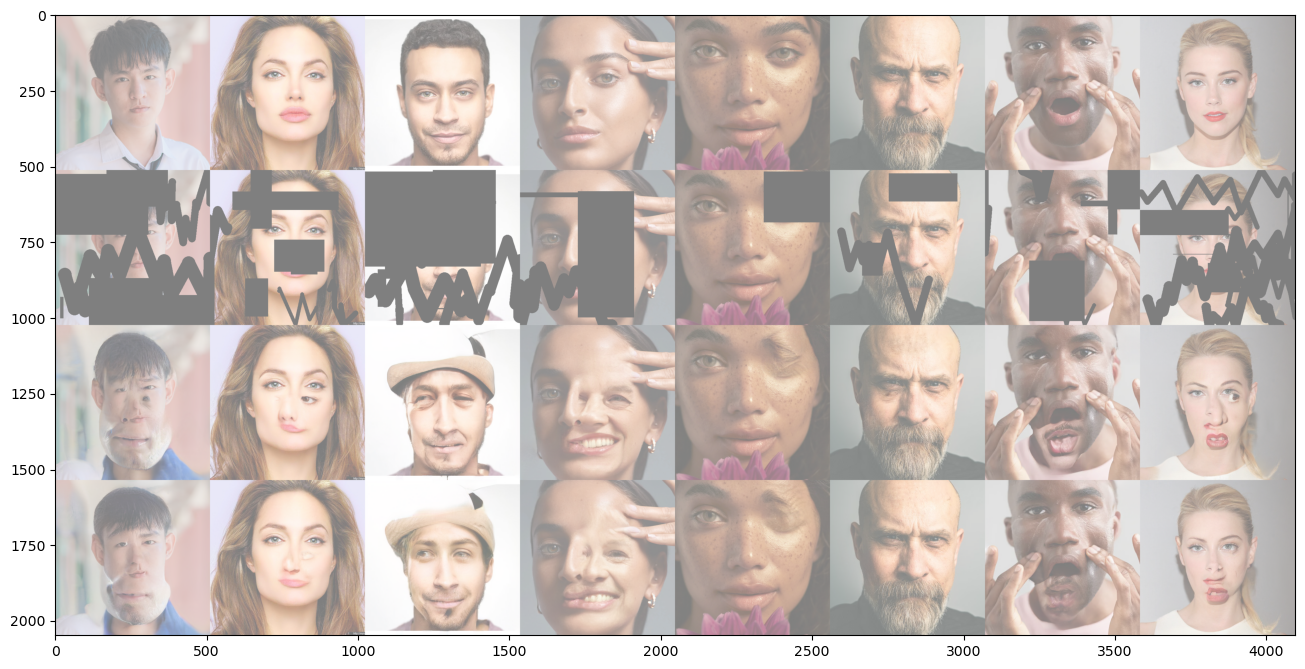

In [5]:
IMG_PATH = '/root/MAT/test_sets/CelebA-HQ/'
full_imgs = []

for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255)
for i in range(8):
    img = mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255
    mask = mpimg.imread(IMG_PATH + 'masks4/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4_stg1/' + str(i) + '.png'))
for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

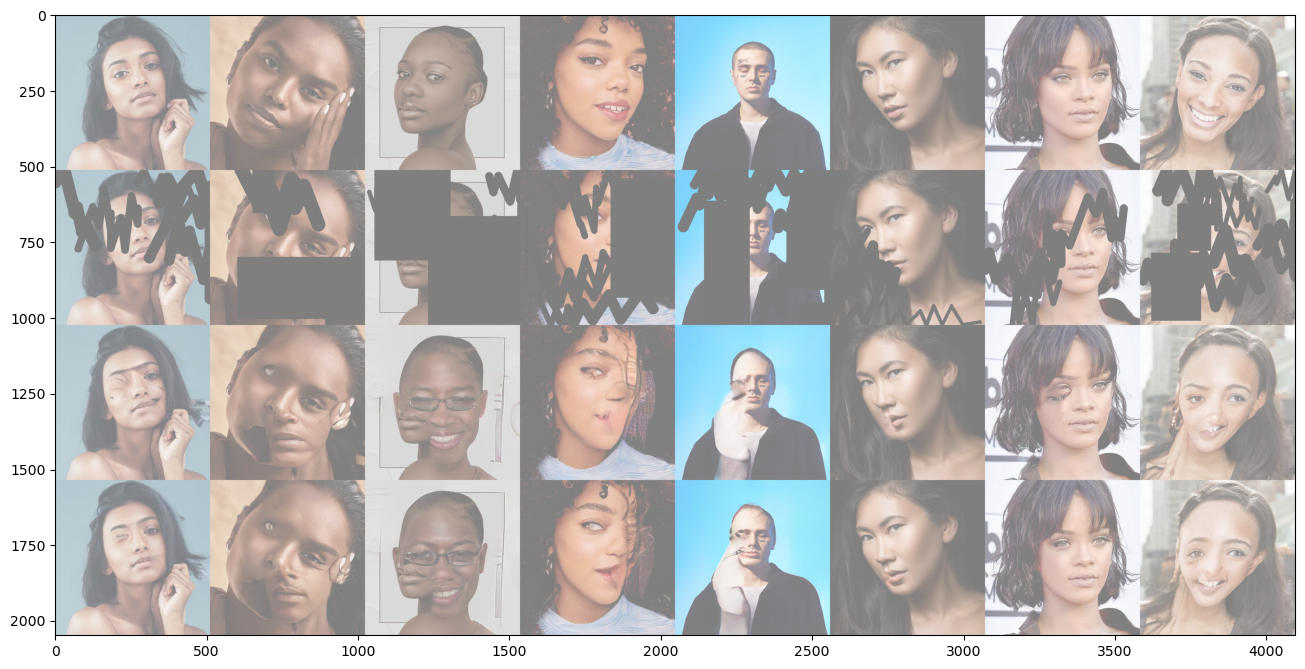

In [7]:
full_imgs = []

for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255)
for i in range(8, 16):
    img = mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255
    mask = mpimg.imread(IMG_PATH + 'masks4/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4_stg1/' + str(i) + '.png'))
for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

In [3]:
fid, pids, uids = cal_fid_pids_uids.calculate_metrics(IMG_PATH + 'samples4/', IMG_PATH + 'images4/')
lpips = cal_lpips.calculate_metrics(IMG_PATH + 'samples4/', IMG_PATH + 'images4/')
psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics(IMG_PATH + 'samples4/', IMG_PATH + 'images4/')

print('fid:', fid)
print('pids:', pids)
print('uids:', uids)
print('lpips:', lpips)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fid: 77.9151933203267
pids: 0.0
uids: 0.0
lpips: 0.16249443357810378
psnr: 21.422315721269733
ssim: 0.824472474259723
l1: 0.04153722251941956
